# Assignment #4: Extracting syntactic groups using machine-learning techniques
Author: Pierre Nugues

In this assignment, you will create a system to extract syntactic groups from a text. You will apply it to the CoNLL 2000 dataset. In addition, you will try to link a few extracted named entities to real things using wikipedia.

## Objectives

The objectives of this assignment are to:
* Write a program to detect partial syntactic structures
* Extract named entities and link them to real things using Wikipedia
* Understand the principles of supervised machine learning techniques applied to language processing
* Use a popular machine learning toolkit: scikit-learn
* Write a short report of 2 to 3 pages on the assignment

## Choosing a training and a test sets

* As annotated data and annotation scheme, you will use the data available from [CoNLL 2000](https://www.clips.uantwerpen.be/conll2000/chunking/).
* Download both the training and test sets and decompress them.
* Local copies are also available here: [train.txt](https://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conll2000/train.txt) and [test.txt](https://fileadmin.cs.lth.se/cs/Education/EDAN20/corpus/conll2000/test.txt)
* Read the description of the CoNLL 2000 task

## Loading the corpus

### The datasets

You may need to adjust the paths to load the datasets.

In [117]:
train_file = 'chunker/train.txt'
test_file = 'chunker/test.txt'

#### Reading the files

Read the functions below to load the datasets. They store the corpus in a list of sentences. Each sentence is a list of rows, where each row is a dictionary.

In [118]:
def read_sentences(file):
    """
    Creates a list of sentences from the corpus
    Each sentence is a string
    :param file:
    :return:
    """
    f = open(file).read().strip()
    sentences = f.split('\n\n')
    return sentences

In [119]:
def split_rows(sentences, column_names):
    """
    Creates a list of sentence where each sentence is a list of lines
    Each line is a dictionary of columns
    :param sentences:
    :param column_names:
    :return:
    """
    new_sentences = []
    for sentence in sentences:
        rows = sentence.split('\n')
        sentence = [dict(zip(column_names, row.split())) for row in rows]
        new_sentences.append(sentence)
    return new_sentences

### Loading dictionaries

The CoNLL 2000 files have three columns

In [120]:
column_names = ['form', 'pos', 'chunk']

We load the corpus

In [121]:
train_sentences = read_sentences(train_file)
train_corpus = split_rows(train_sentences, column_names)
train_corpus[:2]

[[{'form': 'Confidence', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'pound', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'is', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'widely', 'pos': 'RB', 'chunk': 'I-VP'},
  {'form': 'expected', 'pos': 'VBN', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'I-VP'},
  {'form': 'take', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'another', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'sharp', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'dive', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'if', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'trade', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'figures', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': ',', 'pos': ',', 'chunk': 'O'},
  {'form': 'due', 'pos': 'JJ', 'chunk': 'B-ADJP'},
  {'form': 'for', 'pos': 'IN', 'ch

In [122]:
train_sentences = read_sentences(train_file)
train_corpus = split_rows(train_sentences, column_names)
train_corpus[:2]

[[{'form': 'Confidence', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'pound', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'is', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'widely', 'pos': 'RB', 'chunk': 'I-VP'},
  {'form': 'expected', 'pos': 'VBN', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'I-VP'},
  {'form': 'take', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'another', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'sharp', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'dive', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'if', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'trade', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'figures', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': ',', 'pos': ',', 'chunk': 'O'},
  {'form': 'due', 'pos': 'JJ', 'chunk': 'B-ADJP'},
  {'form': 'for', 'pos': 'IN', 'ch

## Baseline chunker

Most statistical algorithms for language processing start with a so-called baseline. The baseline performance corresponds to the application of a minimal technique that is used to assess the difficulty of a task and for comparison with further programs.

You will implement the baseline proposed by the organizers of the
        <a href="https://www.clips.uantwerpen.be/conll2000/chunking/">CoNLL 2000 shared task</a>, Sect. <i>Results</i>.
1. Read it;
2. In the report you will tell what do you think of it.

### Auxiliary functions

A function to count the parts of speech

In [123]:
def count_pos(corpus):
    """
    Computes the part-of-speech distribution
    in a CoNLL 2000 file
    :param corpus:
    :return:
    """
    pos_cnt = {}
    for sentence in corpus:
        for row in sentence:
            if row['pos'] in pos_cnt:
                pos_cnt[row['pos']] += 1
            else:
                pos_cnt[row['pos']] = 1
    return pos_cnt

We first collect all the parts of speech and we count them.

In [124]:
pos_cnt = count_pos(train_corpus)
pos_cnt

{'NN': 30147,
 'IN': 22764,
 'DT': 18335,
 'VBZ': 4648,
 'RB': 6607,
 'VBN': 4763,
 'TO': 5081,
 'VB': 6017,
 'JJ': 13085,
 'NNS': 13619,
 'NNP': 19884,
 ',': 10770,
 'CC': 5372,
 'POS': 1769,
 '.': 8827,
 'VBP': 2868,
 'VBG': 3272,
 'PRP$': 1881,
 'CD': 8315,
 '``': 1531,
 "''": 1493,
 'VBD': 6745,
 'EX': 206,
 'MD': 2167,
 '#': 36,
 '(': 274,
 '$': 1750,
 ')': 281,
 'NNPS': 420,
 'PRP': 3820,
 'JJS': 374,
 'WP': 529,
 'RBR': 321,
 'JJR': 853,
 'WDT': 955,
 'WRB': 478,
 'RBS': 191,
 'PDT': 55,
 'RP': 83,
 ':': 1047,
 'FW': 38,
 'WP$': 35,
 'SYM': 6,
 'UH': 15}

### Chunk distribution

You will compute the chunk distribution for each part of speech. You will use the training file to derive the distribution and you will store the results in a dictionary. Below, you have an excerpt of the expected results:
```
{'JJR':
{'I-ADVP': 17, 'I-ADJP': 45, 'I-NP': 204, 'B-ADVP': 63,
'B-PP': 2, 'B-ADJP': 111, 'B-NP': 382, 'B-VP': 2,
'I-VP': 11, 'O': 16},
'CC':
{'B-ADVP': 3, 'O': 3676, 'I-VP': 104, 'B-CONJP': 6,
'I-ADVP': 30, 'I-UCP': 2, 'I-PP': 24, 'I-ADJP': 26,
'I-NP': 1409, 'B-ADJP': 2, 'B-NP': 18, 'B-PP': 70,
'I-PRT': 1, 'B-VP': 1},
'NN':
{'B-LST': 2, 'I-INTJ': 2, 'B-ADVP': 38, 'O': 37,
'I-ADVP': 11, 'B-INTJ': 1, 'I-UCP': 2, 'B-UCP': 2,
'I-VP': 77, 'B-PRT': 2, 'I-ADJP': 41, 'I-NP': 24456,
'B-ADJP': 44, 'B-NP': 5160, 'B-PP': 15, 'B-VP': 257},
...
```

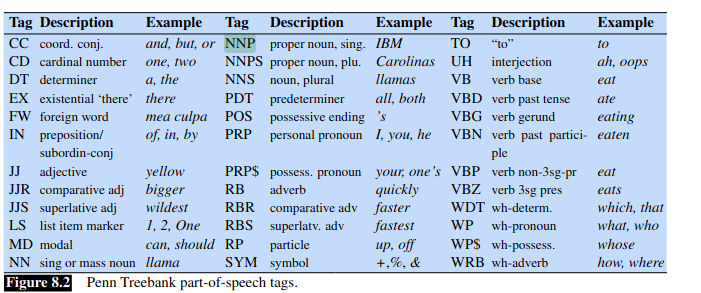

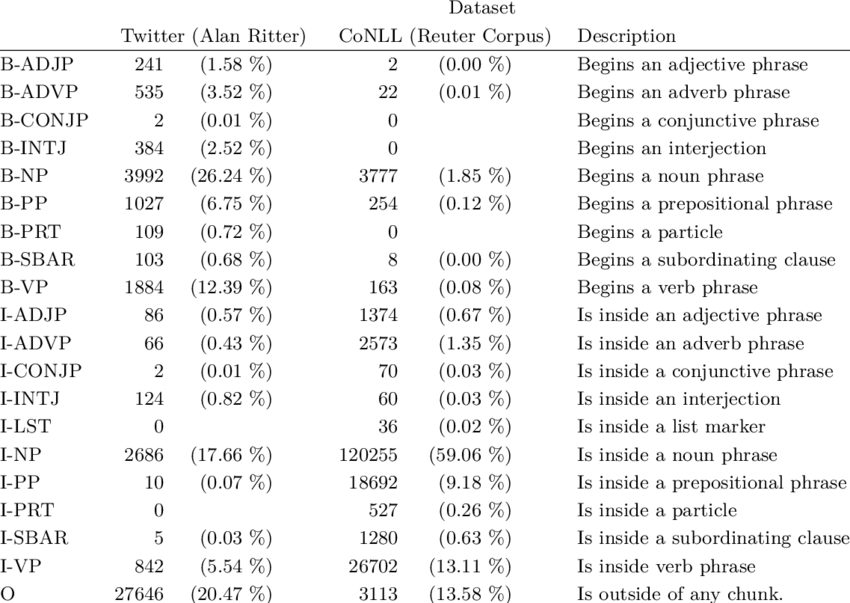

In [125]:
# Write your code here
def chunk_distribution(corpus):
    c_dist = {}
    for sentence in corpus:
        for word_dic in sentence:
            pos = word_dic["pos"]
            chunk = word_dic["chunk"]
            if pos not in c_dist:
                c_dist[pos] = {}
            try:
                c_dist[pos][chunk] += 1
            except:
                c_dist[pos][chunk] = 1
    
    return c_dist

chunk_dist = chunk_distribution(train_corpus)
chunk_dist
#train_corpus[3]

{'NN': {'B-NP': 5160,
  'I-NP': 24456,
  'B-VP': 257,
  'B-ADJP': 44,
  'B-ADVP': 38,
  'O': 37,
  'B-PP': 15,
  'I-ADVP': 11,
  'I-ADJP': 41,
  'I-VP': 77,
  'B-INTJ': 1,
  'B-LST': 2,
  'B-UCP': 2,
  'I-UCP': 2,
  'B-PRT': 2,
  'I-INTJ': 2},
 'IN': {'B-PP': 18683,
  'B-SBAR': 2112,
  'B-ADVP': 396,
  'I-NP': 216,
  'I-SBAR': 68,
  'I-PP': 250,
  'B-PRT': 404,
  'B-NP': 418,
  'B-ADJP': 31,
  'O': 88,
  'I-VP': 20,
  'I-CONJP': 35,
  'I-ADJP': 12,
  'B-CONJP': 4,
  'I-ADVP': 24,
  'B-VP': 3},
 'DT': {'B-NP': 17807,
  'O': 135,
  'I-NP': 299,
  'B-ADVP': 24,
  'I-VP': 7,
  'B-VP': 4,
  'B-INTJ': 6,
  'B-SBAR': 20,
  'I-SBAR': 2,
  'I-ADVP': 15,
  'B-ADJP': 8,
  'I-PP': 1,
  'B-LST': 1,
  'B-PP': 5,
  'I-INTJ': 1},
 'VBZ': {'B-VP': 4469,
  'I-NP': 76,
  'I-INTJ': 2,
  'I-VP': 31,
  'O': 20,
  'B-NP': 49,
  'B-ADVP': 1},
 'RB': {'I-VP': 1258,
  'B-ADVP': 2890,
  'I-ADVP': 250,
  'I-NP': 307,
  'B-ADJP': 399,
  'B-NP': 621,
  'B-SBAR': 68,
  'B-PP': 72,
  'I-PP': 9,
  'O': 344,
  'B-VP': 

In [126]:
chunk_dist['NN']

{'B-NP': 5160,
 'I-NP': 24456,
 'B-VP': 257,
 'B-ADJP': 44,
 'B-ADVP': 38,
 'O': 37,
 'B-PP': 15,
 'I-ADVP': 11,
 'I-ADJP': 41,
 'I-VP': 77,
 'B-INTJ': 1,
 'B-LST': 2,
 'B-UCP': 2,
 'I-UCP': 2,
 'B-PRT': 2,
 'I-INTJ': 2}

In [127]:
chunk_dist['NN']

{'B-NP': 5160,
 'I-NP': 24456,
 'B-VP': 257,
 'B-ADJP': 44,
 'B-ADVP': 38,
 'O': 37,
 'B-PP': 15,
 'I-ADVP': 11,
 'I-ADJP': 41,
 'I-VP': 77,
 'B-INTJ': 1,
 'B-LST': 2,
 'B-UCP': 2,
 'I-UCP': 2,
 'B-PRT': 2,
 'I-INTJ': 2}

### Selecting the POS-chunk associations

For each part of speech, select the best association. In the example above, you will have (NN, I-NP) as it is the most frequent. You will store the results in a dictionary that you will call `pos_chunk`

In [128]:
# Write your code here
#pos_chunk = {keys: max(value, key=value.get) for keys,value in chunk_dist}
def create_pos_chunk():
    p_c = {}
    
    for pos in chunk_dist:
        max_ = 0
        max_chunk = ""
        for chunk in chunk_dist[pos]:
            v = chunk_dist[pos][chunk]
            if(v > max_):
                max_ = v
                max_chunk = chunk
        p_c[pos] = max_chunk
    return p_c

#pos_chunk = {keys: print("keys: " + keys) for keys,value in chunk_dist}
pos_chunk = create_pos_chunk()
pos_chunk['NN']

'I-NP'

In [129]:
pos_chunk['NN']

'I-NP'

### Prediction

Using the resulting associations, apply your chunker to the test file. You will write a `predict(model, corpus)` function, where `model` will be your associations and `corpus`, the test corpus. You will format the test corpus as a dictionary, where you will add a `pchunk` key for each row with a value that will correspond to the predicted chunk.

In [130]:
#pos_chunk
#test_corpus
test_sentences = read_sentences(test_file)
test_corpus = split_rows(test_sentences, column_names)
test_corpus[0][0]

{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'}

In [131]:
# Write your code here
#predicted_test_corpus = predict(pos_chunk, test_corpus)
#predicted_test_corpus[:1]

def predict(model, corpus): #
    for sentence in corpus:
        for word in sentence:
            pos = word['pos']
            word['pchunk'] = model[pos]
    return corpus
predicted_test_corpus = predict(pos_chunk, test_corpus)
predicted_test_corpus[:1]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP', 'pchunk': 'I-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'c

We load the test corpus

In [132]:
test_sentences = read_sentences(test_file)
test_corpus = split_rows(test_sentences, column_names)
test_corpus[:1]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP'},
  {'form': 'contract', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'with', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'Boeing', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'Co.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP'},
  {'form':

We predict the groups. You should have added a `pchunk` key

In [133]:
predicted_test_corpus = predict(pos_chunk, test_corpus)
predicted_test_corpus[:1]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP', 'pchunk': 'I-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'c

### Accuracy

We can evaluate the performance of the baseline with the tag accuracy: the percentage of words that receive the correct tag.

In [134]:
def eval(predicted):
    """
    Evaluates the predicted chunk accuracy
    :param predicted:
    :return:
    """
    word_cnt = 0
    correct = 0
    for sentence in predicted:
        for row in sentence:
            word_cnt += 1
            if row['chunk'] == row['pchunk']:
                correct += 1
    return correct / word_cnt

In [135]:
accuracy = eval(predicted_test_corpus)
accuracy

0.7729066846782194

### The CoNLL evaluation

The accuracy is very misleading as it is biased by the most frequent tags. It is not a good way to evaluate chunking. Instead, CoNLL computes the F1 score of all the chunks with a specific evaluation script.

#### Saving the corpus

To use the CoNLL evaluation script, you will store your results in an output file that has four columns. The three first columns will be the input columns from the test file: 
* word, 
* part of speech, and 
* gold-standard chunk. 

You will append the predicted chunk as the 4th column. Your output file should look like the excerpt below:
```
Rockwell NNP B-NP I-NP
International NNP I-NP I-NP
Corp. NNP I-NP I-NP
's POS B-NP B-NP
Tulsa NNP I-NP I-NP
unit NN I-NP I-NP
said VBD B-VP B-VP
it PRP B-NP B-NP
```
The separator is the space.

You will use a `save_results(output_dict, keys, output_file)` function, where the keys will be `['form', 'pos', 'chunk', 'pchunk']`

In [136]:
keys = ['form', 'pos', 'chunk', 'pchunk']

In [137]:
def save_results(output_dict, keys, output_file):
    f_out = open(output_file, 'w')
    # We write the word (form), part of speech (pos),
    # gold-standard chunk (chunk), and predicted chunk (pchunk)
    for sentence in output_dict:
        for row in sentence:
            for key in keys:
                f_out.write(row[key] + ' ')
            f_out.write('\n')
        f_out.write('\n')
    f_out.close()
    return

In [138]:
save_results(predicted_test_corpus, keys, 'out')

The CoNLL 2000 evaluation script will use these two last columns, chunk and predicted chunk, to compute the performance.

### Evaluation

To evaluate your results, you have two options:
1. Use the original conlleval script here:  <a href="https://www.clips.uantwerpen.be/conll2000/chunking/"><tt>conlleval.txt</tt></a>.
2. Use a Python translation of it. 

You will use the second option and you will describe the results you obtained in your report

#### The Python translation

Install the script with:
```
pip install conlleval
```
from https://github.com/kaniblu/conlleval
and run the cell below

In [139]:
!pip install conlleval

Defaulting to user installation because normal site-packages is not writeable


In [140]:
import conlleval
lines = open('out').read().splitlines()
res = conlleval.evaluate(lines)
baseline_score = res['overall']['chunks']['evals']['f1']

In [141]:
baseline_score

0.770671072299583

### The official script

You may want to double-check your results with the original CoNLL script. It is more complex to use however:
* <tt>conlleval.txt</tt> is the official CoNLL Perl script. It expects the two last columns of the test set to be the manually assigned chunk (gold standard) and the predicted chunk.
* <tt>conlleval.txt</tt> was written for Unix and if you run Windows, you will have to use a terminal command. In the File menu of the notebook, select New and then Terminal.
* Start it like this: ` $ conlleval.txt <out` where the `out` file contains both the gold and predicted chunk tags. `conlleval.txt` is a Perl script.
* Perl is installed on most Unix distributions. If it is not installed on your machine, you need to install it. Make also sure that you have the execution rights. Otherwise change them with: `$ chmod +x conlleval.txt`
* The `conlleval.txt` script expects the new lines to be `\n` as in Unix. If you run your Python program on Windows, your new lines will be `\r\n`. To have the correct new lines, add this parameter to `open()`: `newline='\n’` like this: `f_out = open('out', ‘w’, newline='\n’)`
* The complete description of the CoNLL 2000 evaluation script is available here: [https://www.clips.uantwerpen.be/conll2000/chunking/output.html](https://www.clips.uantwerpen.be/conll2000/chunking/output.html)

## Using Machine Learning: A first ML program

In this exercise, you will apply and explore a machine-learning program.

The program that won the CoNLL 2000 shared task (Kudoh and Matsumoto, 2000) used a window of five words around the chunk tag to identify, $c_i$. They built a feature vector consisting of:
1. The values of the five words in this window: $w_{i-2}, w_{i-1}, w_{i}, w_{i+1}, w_{i+2}$
2. The values of the five parts of speech in this window: $t_{i-2}, t_{i-1}, t_{i}, t_{i+1}, t_{i+2}$
3. The values of the two previous chunk tags in the first part of the window: $c_{i-2}, c_{i-1}$

The two last parameters (3.) are said to be dynamic because the program computes them at run-time. Read [Kudoh and Matsumoto's paper](http://www.clips.uantwerpen.be/conll2000/pdf/14244kud.pdf) and the [Yamcha](http://www.chasen.org/~taku/software/yamcha/) software site.

You will start with a given code that uses the two first sets of features (1. and 2.) and add yourself the last one (3.) to improve the performance of your chunker. Kudoh and Matsumoto trained a classifier based on support vector machines. You will use logistic regression.

### Imports

In [142]:
import bs4
import os
import requests
from sklearn.feature_extraction import DictVectorizer
from sklearn import svm
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import time

### Feature extraction

#### Functions

A first function to extract features from one sentence

In [143]:
def extract_features_sent_static(sentence, w_size, feature_names):
    """
    Extract the features from one sentence
    returns X and y, where X is a list of dictionaries and
    y is a list of symbols
    :param sentence: string containing the CoNLL structure of a sentence
    :param w_size:
    :return:
    """

    # We pad the sentence to extract the context window more easily
    start = [{'form': 'BOS', 'pos': 'BOS', 'chunk': 'BOS'}]
    end = [{'form': 'EOS', 'pos': 'EOS', 'chunk': 'EOS'}]
    start *= w_size
    end *= w_size
    padded_sentence = start + sentence
    padded_sentence += end

    # We extract the features and the classes
    # X contains is a list of features, where each feature vector is a dictionary
    # y is the list of classes
    X = list()
    y = list()
    for i in range(len(padded_sentence) - 2 * w_size):
        # x is a row of X
        x = list()
        # The words in lower case
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j]['form'].lower())
        # The POS
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j]['pos'])
        # The chunks (Up to the word)
        """
        for j in range(w_size):
            feature_line.append(padded_sentence[i + j]['chunk'])
        """
        # We represent the feature vector as a dictionary
        X.append(dict(zip(feature_names, x)))
        # The classes are stored in a list
        y.append(padded_sentence[i + w_size]['chunk'])
    return X, y

And from all the sentences

In [144]:
def extract_features_static(sentences, w_size, feature_names):
    """
    Builds X matrix and y vector
    X is a list of dictionaries and y is a list
    :param sentences:
    :param w_size:
    :return:
    """
    X_l = []
    y_l = []
    for sentence in sentences:
        X, y = extract_features_sent_static(sentence, w_size, feature_names)
        X_l.extend(X)
        y_l.extend(y)
    return X_l, y_l

#### Applying the feature extraction

The size of the window and the names of the features

In [145]:
w_size = 2  # The size of the context window to the left and right of the word
feature_names = ['word_n2', 'word_n1', 'word', 'word_p1', 'word_p2',
                 'pos_n2', 'pos_n1', 'pos', 'pos_p1', 'pos_p2']

We read the corpus and format it as a dictionary

In [146]:
train_sentences = read_sentences(train_file)
train_corpus = split_rows(train_sentences, column_names)

In [147]:
train_corpus[:2]

[[{'form': 'Confidence', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'pound', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'is', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'widely', 'pos': 'RB', 'chunk': 'I-VP'},
  {'form': 'expected', 'pos': 'VBN', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'I-VP'},
  {'form': 'take', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'another', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'sharp', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'dive', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'if', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'trade', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'figures', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': ',', 'pos': ',', 'chunk': 'O'},
  {'form': 'due', 'pos': 'JJ', 'chunk': 'B-ADJP'},
  {'form': 'for', 'pos': 'IN', 'ch

In [148]:
X_dict, y = extract_features_static(train_corpus, w_size, feature_names)
X_dict[:3]

[{'word_n2': 'bos',
  'word_n1': 'bos',
  'word': 'confidence',
  'word_p1': 'in',
  'word_p2': 'the',
  'pos_n2': 'BOS',
  'pos_n1': 'BOS',
  'pos': 'NN',
  'pos_p1': 'IN',
  'pos_p2': 'DT'},
 {'word_n2': 'bos',
  'word_n1': 'confidence',
  'word': 'in',
  'word_p1': 'the',
  'word_p2': 'pound',
  'pos_n2': 'BOS',
  'pos_n1': 'NN',
  'pos': 'IN',
  'pos_p1': 'DT',
  'pos_p2': 'NN'},
 {'word_n2': 'confidence',
  'word_n1': 'in',
  'word': 'the',
  'word_p1': 'pound',
  'word_p2': 'is',
  'pos_n2': 'NN',
  'pos_n1': 'IN',
  'pos': 'DT',
  'pos_p1': 'NN',
  'pos_p2': 'VBZ'}]

In [149]:
y[:2]

['B-NP', 'B-PP']

### Feature encoding

In [150]:
# Vectorize the feature matrix and carry out a one-hot encoding
vec = DictVectorizer(sparse=True)
X = vec.fit_transform(X_dict)

### Training the model

In [151]:
classifier = linear_model.LogisticRegression()
model = classifier.fit(X, y)
model

/home/tocke/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Predicting the test set

We read the sentences and create a dictionary

In [152]:
test_sentences = read_sentences(test_file)
test_corpus = split_rows(test_sentences, column_names)
test_corpus[:2]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP'},
  {'form': 'contract', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'with', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'Boeing', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'Co.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP'},
  {'form':

We extract the features

In [153]:
X_test_dict, y_test = extract_features_static(test_corpus, w_size, feature_names)
X_test_dict[:2]

[{'word_n2': 'bos',
  'word_n1': 'bos',
  'word': 'rockwell',
  'word_p1': 'international',
  'word_p2': 'corp.',
  'pos_n2': 'BOS',
  'pos_n1': 'BOS',
  'pos': 'NNP',
  'pos_p1': 'NNP',
  'pos_p2': 'NNP'},
 {'word_n2': 'bos',
  'word_n1': 'rockwell',
  'word': 'international',
  'word_p1': 'corp.',
  'word_p2': "'s",
  'pos_n2': 'BOS',
  'pos_n1': 'NNP',
  'pos': 'NNP',
  'pos_p1': 'NNP',
  'pos_p2': 'POS'}]

In [154]:
y_test[:2]

['B-NP', 'I-NP']

We vectorize the features

In [155]:
X_test = vec.transform(X_test_dict)  # Possible to add: .toarray()

And we predict the test set

In [156]:
y_test_predicted = classifier.predict(X_test)
y_test_predicted[:2]

array(['B-NP', 'I-NP'], dtype='<U7')

We now add the predicted chunks to the sentences

In [157]:
inx = 0
for sentence in test_corpus:
    for word in sentence:
        word['pchunk'] = y_test_predicted[inx]
        inx += 1

The index sould be equal to the length of the prediction

In [158]:
print(inx)
len(y_test_predicted)

47377


47377

In [159]:
test_corpus[:2]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP', 'pchunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP', 'pchunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP', 'pchunk': 'B-NP'},
  {'form': 'c

In [160]:
save_results(test_corpus, keys, 'out')

#### Evaluating the performance

In [161]:
lines = open('out').read().splitlines()
res = conlleval.evaluate(lines)
simple_ml_score = res['overall']['chunks']['evals']['f1']

In [162]:
simple_ml_score

0.9157688948047087

### Question on the ML program

1. What is the feature vector that corresponds to the <tt>ml_chunker.py</tt> program? Is it the same Kudoh
    and Matsumoto used in their experiment?
2. What is the performance of the chunker?
3. Remove the lexical features (the words) from the feature vector and measure the performance. You should
    observe a decrease.
4. What is the classifier used in the program? 
5. As an optional task, you may try two other classifiers from sklearn and measure their performance: decision trees, perceptron, support vector machines, etc. Be aware that support vector machines take a long time to train: up to one hour.

## Using Machine Learning: Adding all the features from Kudoh and Matsumoto

Complement the feature vector used in the previous section with the two dynamic features, $c_{i-2}, c_{i-1}$, and train a new model. You will need to write a new `extract_features_sent_dyn` and `predict` functions. 
In his experiments, your teacher obtained a F1 score of 92.65 with logistic regression and the default parameters from sklearn, i.e. `linear_model.LogisticRegression()`;

**A frequent mistake in the labs** is to use the gold-standard chunks from the test set. Be aware that  when you predict the test set, you do not know the dynamic features in advance and you must  not use the ones from the test file. You will use the two previous chunk tags that you have predicted.

You need to reach a global F1 score of 92 to pass this laboratory.

In [163]:
### write your code here
def extract_features_sent_dyn(sentence, w_size, feature_names):
    """
    Extract the features from one sentence
    returns X and y, where X is a list of dictionaries and
    y is a list of symbols
    :param sentence: string containing the CoNLL structure of a sentence
    :param w_size:
    :return:
    """

    # We pad the sentence to extract the context window more easily
    start = [{'form': 'BOS', 'pos': 'BOS', 'chunk': 'BOS'}]
    end = [{'form': 'EOS', 'pos': 'EOS', 'chunk': 'EOS'}]
    start *= w_size
    end *= w_size
    padded_sentence = start + sentence
    padded_sentence += end

    # We extract the features and the classes
    # X contains is a list of features, where each feature vector is a dictionary
    # y is the list of classes
    X = list()
    y = list()
    for i in range(len(padded_sentence) - 2 * w_size):
        # x is a row of X
        x = list()
        # The words in lower case
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j]['form'].lower())
        # The POS
        for j in range(2 * w_size + 1):
            x.append(padded_sentence[i + j]['pos'])
        # The chunks (Up to the word)
       
        for j in range(w_size):
            x.append(padded_sentence[i + j]['chunk'])
        
        # We represent the feature vector as a dictionary
        X.append(dict(zip(feature_names, x)))
        # The classes are stored in a list
        y.append(padded_sentence[i + w_size]['chunk'])
    return X, y
        

In [164]:
def extract_features_dyn(sentences, w_size, feature_names):
    """
    Builds X matrix and y vector
    X is a list of dictionaries and y is a list
    :param sentences:
    :param w_size:
    :return:
    """
    X_l = []
    y_l = []
    for sentence in sentences:
        X, y = extract_features_sent_dyn(sentence, w_size, feature_names)
        X_l.extend(X)
        y_l.extend(y)
    return X_l, y_l

In [165]:
feature_names_dyn = ['word_n2', 'word_n1', 'word', 'word_p1', 'word_p2',
                     'pos_n2', 'pos_n1', 'pos', 'pos_p1', 'pos_p2', 'chunk_n2',
                     'chunk_n1']

In [166]:
train_sentences = read_sentences(train_file)
train_corpus = split_rows(train_sentences, column_names)
train_corpus[:2]

[[{'form': 'Confidence', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'pound', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'is', 'pos': 'VBZ', 'chunk': 'B-VP'},
  {'form': 'widely', 'pos': 'RB', 'chunk': 'I-VP'},
  {'form': 'expected', 'pos': 'VBN', 'chunk': 'I-VP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'I-VP'},
  {'form': 'take', 'pos': 'VB', 'chunk': 'I-VP'},
  {'form': 'another', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'sharp', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'dive', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'if', 'pos': 'IN', 'chunk': 'B-SBAR'},
  {'form': 'trade', 'pos': 'NN', 'chunk': 'B-NP'},
  {'form': 'figures', 'pos': 'NNS', 'chunk': 'I-NP'},
  {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': ',', 'pos': ',', 'chunk': 'O'},
  {'form': 'due', 'pos': 'JJ', 'chunk': 'B-ADJP'},
  {'form': 'for', 'pos': 'IN', 'ch

In [167]:
X_dict, y = extract_features_dyn(train_corpus, w_size, feature_names_dyn)

In [168]:
X_dict[:3]

[{'word_n2': 'bos',
  'word_n1': 'bos',
  'word': 'confidence',
  'word_p1': 'in',
  'word_p2': 'the',
  'pos_n2': 'BOS',
  'pos_n1': 'BOS',
  'pos': 'NN',
  'pos_p1': 'IN',
  'pos_p2': 'DT',
  'chunk_n2': 'BOS',
  'chunk_n1': 'BOS'},
 {'word_n2': 'bos',
  'word_n1': 'confidence',
  'word': 'in',
  'word_p1': 'the',
  'word_p2': 'pound',
  'pos_n2': 'BOS',
  'pos_n1': 'NN',
  'pos': 'IN',
  'pos_p1': 'DT',
  'pos_p2': 'NN',
  'chunk_n2': 'BOS',
  'chunk_n1': 'B-NP'},
 {'word_n2': 'confidence',
  'word_n1': 'in',
  'word': 'the',
  'word_p1': 'pound',
  'word_p2': 'is',
  'pos_n2': 'NN',
  'pos_n1': 'IN',
  'pos': 'DT',
  'pos_p1': 'NN',
  'pos_p2': 'VBZ',
  'chunk_n2': 'B-NP',
  'chunk_n1': 'B-PP'}]

In [169]:
X_dict[:3]

[{'word_n2': 'bos',
  'word_n1': 'bos',
  'word': 'confidence',
  'word_p1': 'in',
  'word_p2': 'the',
  'pos_n2': 'BOS',
  'pos_n1': 'BOS',
  'pos': 'NN',
  'pos_p1': 'IN',
  'pos_p2': 'DT',
  'chunk_n2': 'BOS',
  'chunk_n1': 'BOS'},
 {'word_n2': 'bos',
  'word_n1': 'confidence',
  'word': 'in',
  'word_p1': 'the',
  'word_p2': 'pound',
  'pos_n2': 'BOS',
  'pos_n1': 'NN',
  'pos': 'IN',
  'pos_p1': 'DT',
  'pos_p2': 'NN',
  'chunk_n2': 'BOS',
  'chunk_n1': 'B-NP'},
 {'word_n2': 'confidence',
  'word_n1': 'in',
  'word': 'the',
  'word_p1': 'pound',
  'word_p2': 'is',
  'pos_n2': 'NN',
  'pos_n1': 'IN',
  'pos': 'DT',
  'pos_p1': 'NN',
  'pos_p2': 'VBZ',
  'chunk_n2': 'B-NP',
  'chunk_n1': 'B-PP'}]

You will now vectorize the training set

In [170]:
# Write your code
vec= None
vec2 = DictVectorizer(sparse=True)
vec2.fit(X_dict)
X = vec2.transform(X_dict)  # Possible to add: .toarray()

And fit the model

In [171]:
# Write your code
classifier = linear_model.LogisticRegression()
model = classifier.fit(X, y)
model

/home/tocke/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [172]:
model

LogisticRegression()

### Prediction

You will finally predict the test set. We load the corpus again.

In [173]:
test_sentences = read_sentences(test_file)
test_corpus = split_rows(test_sentences, column_names)
test_corpus[:2]

[[{'form': 'Rockwell', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'International', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'Corp.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': "'s", 'pos': 'POS', 'chunk': 'B-NP'},
  {'form': 'Tulsa', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'unit', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'said', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'it', 'pos': 'PRP', 'chunk': 'B-NP'},
  {'form': 'signed', 'pos': 'VBD', 'chunk': 'B-VP'},
  {'form': 'a', 'pos': 'DT', 'chunk': 'B-NP'},
  {'form': 'tentative', 'pos': 'JJ', 'chunk': 'I-NP'},
  {'form': 'agreement', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'extending', 'pos': 'VBG', 'chunk': 'B-VP'},
  {'form': 'its', 'pos': 'PRP$', 'chunk': 'B-NP'},
  {'form': 'contract', 'pos': 'NN', 'chunk': 'I-NP'},
  {'form': 'with', 'pos': 'IN', 'chunk': 'B-PP'},
  {'form': 'Boeing', 'pos': 'NNP', 'chunk': 'B-NP'},
  {'form': 'Co.', 'pos': 'NNP', 'chunk': 'I-NP'},
  {'form': 'to', 'pos': 'TO', 'chunk': 'B-VP'},
  {'form':

Let us extract the static features from one sentence

In [174]:
X_test_dict, y_test = extract_features_static([test_corpus[0]], w_size, feature_names)
X_test_dict[:2]

[{'word_n2': 'bos',
  'word_n1': 'bos',
  'word': 'rockwell',
  'word_p1': 'international',
  'word_p2': 'corp.',
  'pos_n2': 'BOS',
  'pos_n1': 'BOS',
  'pos': 'NNP',
  'pos_p1': 'NNP',
  'pos_p2': 'NNP'},
 {'word_n2': 'bos',
  'word_n1': 'rockwell',
  'word': 'international',
  'word_p1': 'corp.',
  'word_p2': "'s",
  'pos_n2': 'BOS',
  'pos_n1': 'NNP',
  'pos': 'NNP',
  'pos_p1': 'NNP',
  'pos_p2': 'POS'}]

This $\mathbf{X}\_{\textrm{dict}}$ is incomplete. For the prediction, we need to reinject dynamically the two previously predicted tags to have the full feature vector. Write this code here. 

This part is probably the most difficult of the lab. You may want to write it first for one sentence, and then for the test corpus. The prediction will take a longer time and you may want to include a progress bar with this snippet: 
```
from tqdm import tqdm
for test_sentence in tqdm(test_corpus):
```

In [175]:
y_test_predicted_dyn = []


In [176]:
from tqdm import tqdm
for test_sentence in tqdm(test_corpus):
    X_test_dict, y_test = extract_features_dyn([test_sentence], w_size, feature_names)
    
    chunk_n1 = 'BOS'
    chunk_n2 = 'BOS'
    
    for row in X_test_dict:
        row['chunk_n1'] = chunk_n1
        row['chunk_n2'] = chunk_n2
        
        chunk = model.predict(vec2.transform(row))
        chunk_n2 = chunk_n1
        chunk_n1 = chunk
        y_test_predicted_dyn.append(chunk.tolist())

# from tqdm import tqdm
# for index, test_sentence in tqdm(enumerate(test_corpus)):
#     X_test_dict, y_test = extract_features_dyn([test_corpus[index]], w_size, feature_names)
#     breakpoint()
#     tmp = vec.transform(X_test_dict)
#     y_test_predicted_dyn.append(model.predict(tmp))
    

# # def predict(model, corpus): #
# #     for sentence in corpus:
# #         for word in sentence:
# #             pos = word['pos']
# #             word['pchunk'] = model[pos]
# #     return corpus

100%|█████████████████████████████████████████████████████████| 2012/2012 [01:36<00:00, 20.81it/s]


In [177]:
tmp = [item for sublist in y_test_predicted_dyn for item in sublist]
y_test_predicted_dyn = tmp
y_test_predicted_dyn[:3]

#y_test_pred_dyn = []

['B-NP', 'I-NP', 'I-NP']

In [178]:
# write your code here

In [179]:
y_test_predicted_dyn[:3]

['B-NP', 'I-NP', 'I-NP']

In [180]:
inx = 0
for sentence in test_corpus:
    for word in sentence:
        word['pchunk'] = y_test_predicted_dyn[inx]
        inx += 1

In [181]:
save_results(test_corpus, keys, 'out')

#### Evaluation

In [182]:
lines = open('out').read().splitlines()
res = conlleval.evaluate(lines)
improved_ml_score = res['overall']['chunks']['evals']['f1']
improved_ml_score

0.9265266775640221

### Optional improvement

As an optional task, you can try to improve the score with beam search. If you know this technique, apply it using the probability output of logistic regression.

With the same classifier and a beam diameter of 5, your teacher obtained 92.87.

## Collecting the entities

You will now collect all the named entities from the training set, defined as NP chunks and starting with a `NNP` (proper noun) or a `NNPS` (proper noun, plural) tag. As an example, in the first sentence of `train_corpus`, you will extract `('September', )` and `('July', 'and', 'August')`. You will set all the tuples in a set that you will call `ne_set`.

In [183]:
train_corpus[0]

[{'form': 'Confidence', 'pos': 'NN', 'chunk': 'B-NP'},
 {'form': 'in', 'pos': 'IN', 'chunk': 'B-PP'},
 {'form': 'the', 'pos': 'DT', 'chunk': 'B-NP'},
 {'form': 'pound', 'pos': 'NN', 'chunk': 'I-NP'},
 {'form': 'is', 'pos': 'VBZ', 'chunk': 'B-VP'},
 {'form': 'widely', 'pos': 'RB', 'chunk': 'I-VP'},
 {'form': 'expected', 'pos': 'VBN', 'chunk': 'I-VP'},
 {'form': 'to', 'pos': 'TO', 'chunk': 'I-VP'},
 {'form': 'take', 'pos': 'VB', 'chunk': 'I-VP'},
 {'form': 'another', 'pos': 'DT', 'chunk': 'B-NP'},
 {'form': 'sharp', 'pos': 'JJ', 'chunk': 'I-NP'},
 {'form': 'dive', 'pos': 'NN', 'chunk': 'I-NP'},
 {'form': 'if', 'pos': 'IN', 'chunk': 'B-SBAR'},
 {'form': 'trade', 'pos': 'NN', 'chunk': 'B-NP'},
 {'form': 'figures', 'pos': 'NNS', 'chunk': 'I-NP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
 {'form': 'September', 'pos': 'NNP', 'chunk': 'B-NP'},
 {'form': ',', 'pos': ',', 'chunk': 'O'},
 {'form': 'due', 'pos': 'JJ', 'chunk': 'B-ADJP'},
 {'form': 'for', 'pos': 'IN', 'chunk': 'B-PP'},
 {'fo

You can write a two-pass procedure. For each sentence of the corpus:
1. In the first pass, you will collect the start indices of the noun groups which are also proper nouns. For the first sentence, it will result in the list `[16, 30]`;
2. In the second pass, you will collect the segments, starting at each index. For the first sentence, it will result in the tuples `('September',)`and `('July', 'and', 'August')`

Should you have a better solution, please use it.

In [208]:
# Write your code here
ne_set = []
for sentence in train_corpus:
    indexes = []
    for index, row in enumerate(sentence):
        if (row["pos"] == "NNP" or row["pos"] == "NNPS") and "B-NP" in row["chunk"]:
            indexes.append(index)

    for i in indexes:
        last_noun = False
        tmp = i
        segments=[]
        while not last_noun:
            try:
                name = sentence[tmp]['form']
                pos = sentence[tmp]['pos']
                chunk = sentence[tmp]['chunk']
            except:
                break
            if ((pos =='NNP' or pos == 'NNPS') and chunk == 'B-NP'):
                segments.append(name)
                tmp += 1
            elif tmp != i and (chunk == 'I-NP'):
                segments.append(name)
                tmp += 1
            else:
                last_noun = True
        if segments:
            ne_set.append(tuple(segments))
    
ne_set = set(ne_set)


In [209]:
len(ne_set)

4366

In [195]:
len(ne_set)

4348

In [204]:
list(ne_set)[:10]

[('Westridge', 'Capital'),
 ('Mr.', 'Peake'),
 ('Latin', 'America'),
 ('DOE',),
 ('GTE',),
 ('Terrorism', 'and', 'Narcotics'),
 ('Sam', 'Houston'),
 ('John', 'Morton'),
 ('Nov', ',', '27', ',', '1989'),
 ('Healthcare',)]

In [63]:
list(ne_set)[:10]

[('Streetspeak',),
 ('Valley', 'National', 'Corp.'),
 ('Chemical', 'Securities', 'Inc.'),
 ('National', 'Westminister', 'Bank'),
 ('Nov.', '15', ',', '1999'),
 ('San', 'Francisco', 'International'),
 ('Merrill', 'Lynch', 'Capital', 'Markets'),
 ('Hollywood',),
 ('Mary', 'E.', 'Sommer'),
 ('John', 'S.', 'Reidy')]

### Creating a small set

To run the subsequent experiments faster, you will limit the dataset to the entities starting with letter _K_. I chose this letter, because it corresponded to one of the smallest sets. You will call the resulting set: `ne_small_set`. Feel free to use the full set after you have completed this assignment.

In [207]:
# Write your code here
ne_small_set = [tup for tup in set(ne_set) if tup[0].startswith("K")]
ne_small_set[:10]

[('Kenneth', 'T.', 'Rosen'),
 ('Keizaikai', 'Corp.'),
 ('Kwek', 'Hong', 'Png'),
 ('Keizaikai',),
 ('Kathe', 'Dillmann'),
 ('King', 'Broadcasting', 'Co.'),
 ('Khost',),
 ('Kroger', 'Co'),
 ('KIM',),
 ('Kirin', 'Brewery')]

In [65]:
ne_small_set

[('Kathie', 'Roberts'),
 ('Keith', 'L.', 'Fogg'),
 ('Kansas', 'and', 'Texas'),
 ('Kringle', 'fares'),
 ('Ky.',),
 ('Keith', 'Mulrooney'),
 ('Kirin', 'Brewery'),
 ('Kent', 'Neal'),
 ('Kenneth', 'T.', 'Rosen'),
 ('Kuala', 'Lumpur'),
 ('Keizaikai', 'Corp.'),
 ('Kidder', ',', 'Peabody', '&', 'Co.'),
 ('Kathryn', 'McGrath'),
 ('Kobe', 'Steel', 'Ltd.'),
 ('Kathie', 'Huff'),
 ('Kary', 'Moss'),
 ('Kathy', 'Stanwick'),
 ('Khost',),
 ('Ke', 'Zaishuo'),
 ('Kidder', ',', 'Peabody', '&', 'Co'),
 ('Kirin',),
 ('KTXL',),
 ('Kabul',),
 ('Kaitaia',),
 ('Kidder', 'Peabody'),
 ('Kevin', 'Logan'),
 ('King', 'Broadcasting', 'Co.'),
 ('Kinney', 'and', 'Foot', 'Locker', 'shoe', 'stores'),
 ('Kimberly', 'Ann', 'Smith'),
 ('Kwek', 'Hong', 'Png'),
 ('Keihin', 'Electric', 'Express', 'Railway', 'Co'),
 ('Kraft', 'General', 'Foods'),
 ('Kenneth', 'A.', 'Eldred'),
 ('K', 'mart', 'Corp.', 'Chairman', 'Joseph', 'E.', 'Antonini'),
 ('KLM', 'Royal', 'Dutch', 'Airlines'),
 ('Kacy', 'McClelland'),
 ('Kitchen',),
 ('Kathe

## Resolving the entities

You will now implement a simple method to find the named entities from the previous exercise in Wikipedia and Wikidata.

First, look at a few entities in your set and find:
1. a few entities that you think are in wikipedia, 
2. entities that will not be in wikipedia, and 
3. entities that you think are ambiguous: An entity that may correspond to two or more things. 

You will describe your findings in the report.

### A function to lookup entities

Read the function below and try to understand what it means. You will describe it in your report.

In [210]:
def wikipedia_lookup(ner, base_url='https://en.wikipedia.org/wiki/'):
    try:
        url_en = base_url + ' '.join(ner)
        html_doc = requests.get(url_en).text
        parse_tree = bs4.BeautifulSoup(html_doc, 'html.parser')
        entity_id = parse_tree.find("a", {"accesskey": "g"})['href']
        head_id, entity_id = os.path.split(entity_id)
        return entity_id
    except:
        pass
        # print('Not found in: ', base_url)
    entity_id = 'UNK'
    return entity_id

Write a function to run the lookup and keep the resolved entities (only the resolved entities). You will call it `ne_ids_en`

In [218]:
ne_ids_en = []
for tuples in tqdm(ne_small_set):
    for word in tuples:
        ne_ids_en.append((tuples, wikipedia_lookup(word)))
ne_ids_en = set(ne_ids_en )

100%|█████████████████████████████████████████████████████████████| 76/76 [00:32<00:00,  2.37it/s]


In [67]:
#Write your code here

100%|██████████| 76/76 [01:15<00:00,  1.01it/s]


In [ ]:
ne_ids_en

Sometimes, entities need a confirmation. You will apply the resolution with the Swedish wikipedia.

In [219]:
ne_ids_sv = []
for tuples in tqdm(ne_small_set):
    for word in tuples:
        ne_ids_sv.append((tuples, wikipedia_lookup(word, "https://sv.wikipedia.org/wiki/")))
ne_ids_sv = set(ne_ids_sv )

100%|█████████████████████████████████████████████████████████████| 76/76 [00:35<00:00,  2.14it/s]


In [ ]:
ne_ids_sv

You will compute the intersection of the two sets. You will assign it to a list that you will sort and that you will call: `confirmed_ne_en_sv`.

In [221]:
# Write your code here
confirmed_ne_en_sv = ne_ids_sv.intersection(ne_ids_en)

In [222]:
confirmed_ne_en_sv = (word for word in c]

{(('K', 'mart', 'Corp.', 'Chairman', 'Joseph', 'E.', 'Antonini'), 'Q9922'),
 (('K', 'mart', 'Corp.', 'Chairman', 'Joseph', 'E.', 'Antonini'), 'UNK'),
 (('K-H', 'Corp.'), 'UNK'),
 (('KIM',), 'UNK'),
 (('KLM', 'Royal', 'Dutch', 'Airlines'), 'UNK'),
 (('KPMG', 'Peat', 'Marwick'), 'UNK'),
 (('KTXL',), 'UNK'),
 (('Kabul',), 'UNK'),
 (('Kacy', 'McClelland'), 'UNK'),
 (('Kaitaia',), 'UNK'),
 (('Kajima',), 'UNK'),
 (('Kansas',), 'UNK'),
 (('Kansas', 'Power'), 'UNK'),
 (('Kansas', 'and', 'Texas'), 'UNK'),
 (('Karen', 'Olshan'), 'UNK'),
 (('Kary', 'Moss'), 'UNK'),
 (('Kasler', 'Corp.'), 'UNK'),
 (('Kate', 'Michelman'), 'UNK'),
 (('Kathe', 'Dillmann'), 'UNK'),
 (('Kathie', 'Huff'), 'UNK'),
 (('Kathie', 'Roberts'), 'UNK'),
 (('Kathryn', 'McGrath'), 'UNK'),
 (('Kathy', 'Stanwick'), 'UNK'),
 (('Katonah',), 'UNK'),
 (('Kawasaki', 'Steel'), 'UNK'),
 (('Ke', 'Zaishuo'), 'UNK'),
 (('Kean', 'forces'), 'UNK'),
 (('Keefe', ',', 'Bruyette', '&', 'Woods', 'Inc.'), 'Q11213'),
 (('Keefe', ',', 'Bruyette', '&',

In [ ]:
confirmed_ne_en_sv

The first items in your list should look like:
```
[(('KIM',), 'Q224736'),
 (('KLM', 'Royal', 'Dutch', 'Airlines'), 'Q181912'),
 ...
]
```

## Submission

When you have written all the code and run all the cells, fill in your ID and as well as the name of the notebook.

In [73]:
STIL_ID = ["da20exampl-s", "ad02exampl-z"] # Write your stil ids as a list
CURRENT_NOTEBOOK_PATH = os.path.join(os.getcwd(), 
                                     "4-chunker_solution.ipynb") # Write the name of your notebook

The submission code will send your answer. It consists of the baseline score, the improved machine-learning score, and the confirmed entities.

In [ ]:
import json
ANSWER = json.dumps({'baseline_score': baseline_score,
                    'improved_ml_score': improved_ml_score,
                    'confirmed_ne_en_sv': confirmed_ne_en_sv})
ANSWER

Now the moment of truth:
1. Save your notebook and
2. Run the cells below

In [89]:
SUBMISSION_NOTEBOOK_PATH = CURRENT_NOTEBOOK_PATH + ".submission.bz2"

In [90]:
import bz2
ASSIGNMENT = 4
API_KEY = "f581ba347babfea0b8f2c74a3a6776a7"

# Copy and compress current notebook
with bz2.open(SUBMISSION_NOTEBOOK_PATH, mode="wb") as fout:
    with open(CURRENT_NOTEBOOK_PATH, "rb") as fin:
        fout.write(fin.read())

In [93]:
res = requests.post("https://vilde.cs.lth.se/edan20checker/submit", 
                    files={"notebook_file": open(SUBMISSION_NOTEBOOK_PATH, "rb")}, 
                    data={
                        "stil_id": STIL_ID,
                        "assignment": ASSIGNMENT,
                        "answer": ANSWER,
                        "api_key": API_KEY,
                    },
               verify=True)

# from IPython.display import display, JSON
res.json()

{'msg': None,
 'status': 'correct',
 'signature': '44d25dade9b27ca3958bb540a9c4162853e05c9858a8d72dedfcc3847fa253f493793ac464ec821aa9e51f2b3d36799d67ce93183182c1a0d001969f313f6682',
 'submission_id': 'ba27ca6b-e185-4bd0-a357-47c2ed817e68'}

## Reading

You will read the article, <a href="https://www.aclweb.org/anthology/C18-1139"><i>Contextual String
            Embeddings for Sequence Labeling</i></a> by Akbik et al. (2018)
            and you will outline the main differences between their system and yours. A LSTM is a type of
            recurrent neural network, while CRF is a sort of beam search. You will tell the performance
            they reach on the corpus you used in this laboratory.